# Classificação de Células Cancerígenas de Pulmão e Cólon

Este colab contém o treinamento das VGG-13 em **20 épocas** com uma taxa de aprendizagem **0.0006**.

Disciplina de Introdução a Aprendizagem Profunda (IF867)

Alunos:

*   Davi Monteiro Paiva (dmp)
*   Isabela Marinho Ribeiro (imr)
*   Michel Leonidas Aleixo da Silva (mlas3)

## Importação do dataset
Instalando Kaggle e o Pandas:

In [ ]:
!pip install kaggle
!pip install pandas

In [ ]:
 from google.colab import files

Upload do arquivo que contém a chave da API do Kaggle:

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belamarib","key":"3907e52f3f3775ffee895af247c93528"}'}

Criação do diretório para a leitura da chave Kaggle:

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Autenticação e download do dataset:

In [ ]:
# Authenticate using your Kaggle API credentials
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Use the 'dataset_download_files' method to download the dataset
api.dataset_download_files('andrewmvd/lung-and-colon-cancer-histopathological-images')

# The dataset will be downloaded as a zip file, you can unzip it
import zipfile
with zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset-folder')  # Extract to a specific folder

Importação de bibliotecas:

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

Separação das pastas de cada classe:

In [ ]:
# Define the path to the dataset folder
dataset_path = '/content/dataset-folder/lung_colon_image_set'

# List the subfolders (classes) in the dataset folder
class_names = os.listdir(dataset_path)
class_names.sort()  # Sort for consistency

colon_folder = os.path.join(dataset_path, class_names[0])
lung_folder = os.path.join(dataset_path, class_names[1])

In [ ]:
lung_folder

'/content/dataset-folder/lung_colon_image_set/lung_image_sets'

## Visualização dos dados
Tecidos de cólon:

<Figure size 1500x1000 with 0 Axes>

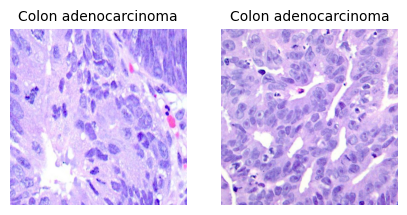

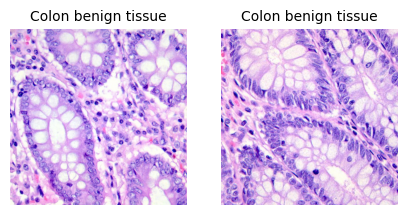

In [ ]:
plt.figure(figsize=(15, 10))
colon_path = []
titles = ["Colon adenocarcinoma", "Colon benign tissue"]

for j, image_file in enumerate(os.listdir(colon_folder)):
    image_path = os.path.join(colon_folder, image_file)
    image_files = os.listdir(image_path)

    # Load and display images in a 2x2 grid
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))

    colon_path.append(image_path)
    for i, ax in enumerate(axes.flat):
        path = os.path.join(image_path,image_files[i])
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(titles[j], fontsize=10)
        ax.axis('off')  # Turn off axis numbers and ticks


    plt.show()

Tecidos de pulmão:

<Figure size 1500x1000 with 0 Axes>

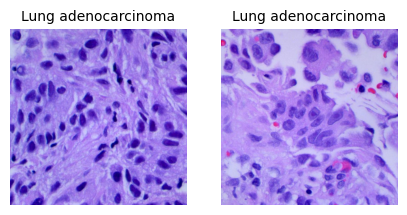

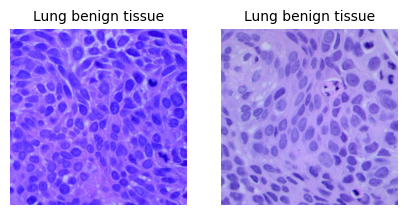

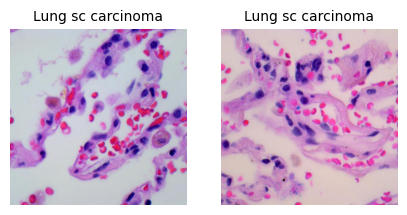

In [ ]:
plt.figure(figsize=(15, 10))
plt.clf()
titles = ["Lung adenocarcinoma", "Lung benign tissue", "Lung sc carcinoma"]
lung_path = []

for j, image_file in enumerate(os.listdir(lung_folder)):
    image_path = os.path.join(lung_folder, image_file)
    image_files = os.listdir(image_path)

    # Load and display images in a 2x2 grid
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))

    lung_path.append(image_path)
    for i, ax in enumerate(axes.flat):
        path = os.path.join(image_path,image_files[i])
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(titles[j], fontsize=10)
        ax.axis('off')  # Turn off axis numbers and ticks


    plt.show()

## Tratamento dos dados
Preparação das labels:

In [ ]:
Y_label = [
  'Colon Adenocarcinoma',
  'Colon Benign Tissue',
  'Lung Benign Tissue',
  'Lung Adenocarcinoma',
  'Lung Squamous Cell Carcinoma',
]
Y_label_num = [0,1,2,3,4]

Criação de array com as labels na mesma ordem dos resultados:

In [ ]:
import torch

filepaths = colon_path + lung_path

labels = []
all_imgs = []

for i, fl in enumerate(filepaths):
    flist = os.listdir(fl)
    for img in flist:
      f_path = os.path.join(fl, img)
      all_imgs.append(f_path)
      labels.append(Y_label_num[i])

labels = torch.tensor(labels)

Divisão dos dados em treino e teste usando o valor 123 para o random state, de forma a garantir que os modelos vão ser treinados com os mesmos dados:

In [ ]:
from sklearn.model_selection import train_test_split
# train dataframe
x_train, x_test, y_train, y_test = train_test_split(all_imgs, labels, test_size=0.2, shuffle= True, random_state= 123)

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision.transforms as transforms

Classe que faz os dataloaders de cada modelo:

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels,  transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]


## Treinamentos e testes com redes pré-treinadas

### VGG 13
Download do modelo:

In [ ]:
model = torchvision.models.vgg13(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:02<00:00, 192MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainset = CustomDataset(x_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [ ]:
testset = CustomDataset(x_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)

In [ ]:
model.classifier[6] = nn.Linear(4096, 5)

Treinamento:

In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_progress = []
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Training epoch {epoch+1}...")
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(trainloader)}")
    loss_progress.append(running_loss / len(trainloader))

Training epoch 1...
Epoch [1/20] - Loss: 0.62207614736557
Training epoch 2...
Epoch [2/20] - Loss: 0.2589164137929678
Training epoch 3...
Epoch [3/20] - Loss: 0.16078384846895932
Training epoch 4...
Epoch [4/20] - Loss: 0.12762469096519052
Training epoch 5...
Epoch [5/20] - Loss: 0.12960183824766427
Training epoch 6...
Epoch [6/20] - Loss: 0.11543717267075554
Training epoch 7...
Epoch [7/20] - Loss: 0.08224992579333484
Training epoch 8...
Epoch [8/20] - Loss: 0.07067183792325668
Training epoch 9...
Epoch [9/20] - Loss: 0.058871157414093614
Training epoch 10...
Epoch [10/20] - Loss: 0.050555217449832705
Training epoch 11...
Epoch [11/20] - Loss: 0.06953900123526109
Training epoch 12...
Epoch [12/20] - Loss: 0.12072831645259284
Training epoch 13...
Epoch [13/20] - Loss: 0.06098160115357023
Training epoch 14...
Epoch [14/20] - Loss: 0.040147645953574104
Training epoch 15...
Epoch [15/20] - Loss: 0.07256342778614198
Training epoch 16...
Epoch [16/20] - Loss: 0.05351358633388445
Training ep

Gráfico da loss:

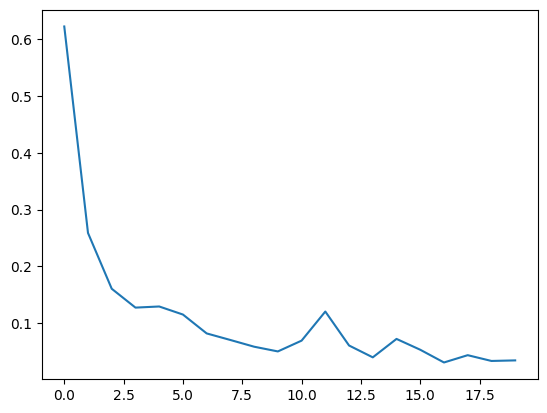

In [ ]:
plt.figure()
plt.plot(loss_progress)

Avaliação do modelo:

In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:  # Assuming you have a separate DataLoader for testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the predicted class

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 98.26%


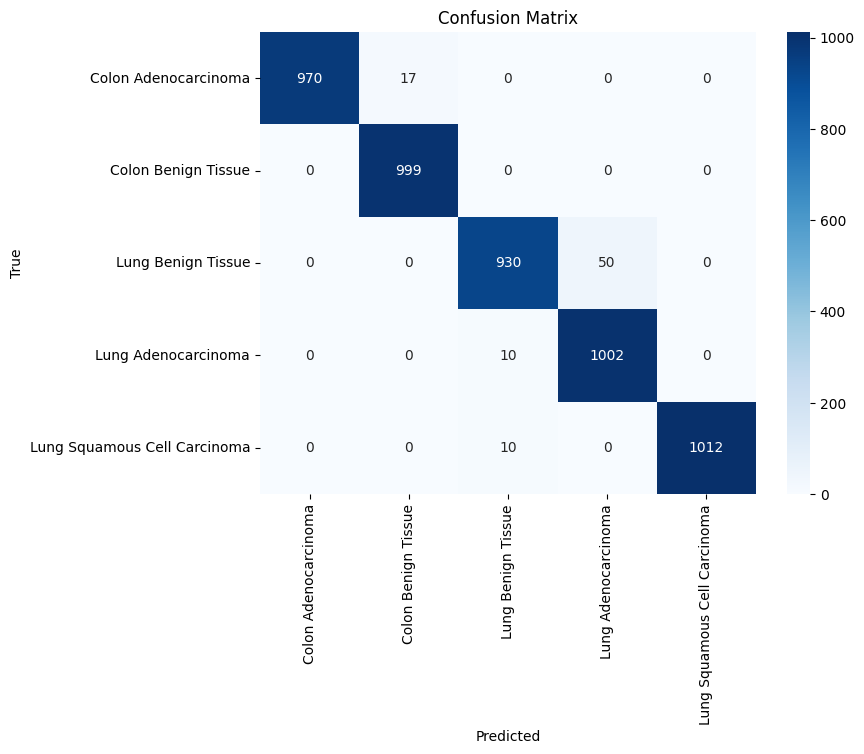

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Y_label, yticklabels=Y_label)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()